In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

### Reading ANIMELIST.CSV

In [3]:
import os

In [4]:
INPUT_DIR=os.path.join("..","artifacts","raw")

In [5]:
rating_df=pd.read_csv(INPUT_DIR+"/animelist.csv",low_memory=True,usecols=["user_id","anime_id","rating"])

In [6]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
rating_df.shape

(7000000, 3)

### DATA PROCESSING

In [8]:
n_ratings=rating_df["user_id"].value_counts()

In [9]:
n_ratings

user_id
20807    17546
11100    14429
22022    13696
16869     8943
10255     8403
         ...  
13606        1
15566        1
9020         1
17067        1
26           1
Name: count, Length: 21103, dtype: int64

In [10]:
rating_df=rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>400].index)].copy()

In [11]:
rating_df

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0
...,...,...,...
6999995,22944,4214,0
6999996,22944,2000,0
6999997,22944,64,0
6999998,22944,65,0


In [12]:
min_rating=min(rating_df["rating"])
min_rating

0

In [13]:
max_rating=max(rating_df["rating"])
max_rating

10

In [14]:
avg_rating=np.mean(rating_df["rating"])
avg_rating

np.float64(4.072611611849041)

In [15]:
#doing scaling for rating column (Min-Max Scaling)
rating_df["rating"]=rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)


In [16]:
np.mean(rating_df["rating"])

np.float64(0.407261161184904)

In [17]:
## Checking duplicates
rating_df.duplicated().sum()

np.int64(0)

In [18]:
### Checking for null values
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [ ]:

user_ids=rating_df["user_id"].unique().tolist()
user2user_encoded={x : i for i,x in enumerate(user_ids)}
user2user_decoded={i : x for i,x in enumerate(user_ids)}
rating_df["user"]=rating_df["user_id"].map(user2user_encoded)#User to user encoding for our model
### userid--->10056 ----->97
 #creates another oclumn of user encoded for machine

In [20]:
rating_df

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0
...,...,...,...,...
6999995,22944,4214,0.0,5828
6999996,22944,2000,0.0,5828
6999997,22944,64,0.0,5828
6999998,22944,65,0.0,5828


In [21]:
n_users=len(user2user_encoded)
n_users

5829

In [22]:
## Doing same for anime_id column


anime_ids=rating_df["anime_id"].unique().tolist()
anime2anime_encoded={x : i for i,x in enumerate(anime_ids)}
anime2anime_decoded={i : x for i,x in enumerate(anime_ids)}
rating_df["anime"]=rating_df["anime_id"].map(anime2anime_encoded) #creates another oclumn of user encoded for machine

In [23]:
rating_df

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4
...,...,...,...,...,...
6999995,22944,4214,0.0,5828,1574
6999996,22944,2000,0.0,5828,5417
6999997,22944,64,0.0,5828,727
6999998,22944,65,0.0,5828,730


In [24]:
n_anime=len(anime2anime_encoded)
n_anime

17553

In [25]:
## Shuffling data so that our model learns pattern on random data.LearningRateScheduler 
rating_df=rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [26]:
rating_df

,user_id,anime_id,rating,user,anime
0,16418,21797,0.0,4167,2247
1,21090,16051,0.0,5368,2196
2,781,7060,0.0,206,10547
3,21935,31139,0.0,5576,4302
4,7048,37999,0.9,1763,1482
...,...,...,...,...,...
4553275,5929,3011,0.6,1479,6087
4553276,7928,30014,0.0,2002,3188
4553277,7522,777,0.9,1896,193
4553278,12688,38524,0.7,3201,405


In [27]:
X=rating_df[["user","anime"]].values
y=rating_df["rating"]

In [28]:
test_size=1000
train_indices=rating_df.shape[0]-test_size

In [29]:
X_train,X_test,y_train,y_test=(
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [30]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4552280, 2), (1000, 2), (4552280,), (1000,))

In [31]:
type(X_train)

numpy.ndarray

In [32]:
#Storing the input features as a list
X_train_array=[X_train[:,0],X_train[:,1]]
X_test_array=[X_test[:,0],X_test[:,1]]

In [33]:
type(X_test_array)

list

### MODEL ARCHITECTURE

In [34]:
def RecommendorNet():
    embeddiing_size=128  #no of vectors

    user=Input(name="user",shape=[1])

    user_embedding=Embedding(name="user_embedding",input_dim=n_users,output_dim=embeddiing_size)(user) #the embedding layer would be working on input layer

    anime=Input(name="anime",shape=[1])

    anime_embedding=Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embeddiing_size)(anime)

    x=Dot(name="dot_product",normalize=True,axes=2)([user_embedding,anime_embedding]) #similarities between user and anime

    x=Flatten()(x) #Convertws high dimensional vector into single dimensional vector

    x=Dense(1,kernel_initializer="he_normal")(x)
    x=BatchNormalization()(x)
    x=Activation("sigmoid")(x)

    model=Model(inputs=[user,anime],outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer="Adam")

    return model


In [35]:
model=RecommendorNet()

In [36]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    746,112 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,246,784 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,992,902 (11.42 MB)

 Trainable params: 2,992,900 (11.42 MB)

 Non-trainable params: 2 (8.00 B)

In [37]:
start_lr=0.00001
min_lr=0.0001
max_lr=0.00005
batch_size=10000

ramup_epochs=5
sustain_epochs=0
exp_decay=0.8

#for finding best learning rate for our model
def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch+start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr)*exp_decay**(epoch-ramup_epochs-sustain_epochs)+min_lr

In [38]:
lr_callback=LearningRateScheduler(lambda epoch:lrfn(epoch),verbose=0)
checkpoint_filepath='./weights.weights.h5'

model_checkpoint=ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping=EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)

In [39]:
my_callbacks=[model_checkpoint,lr_callback,early_stopping]

In [ ]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import tensorflow as tf

history=model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array,y_test),
    callbacks=my_callbacks
)

In [41]:
# metrics=["loss","mae","mse"]

# fig,axes=plt.subplots(len(metrics),1,figsize=(8,len(metrics)*4))

# for i,metric in enumerate(metrics):
#     ax=axes[i]
#     ax.plot(history.history[metric][0:-2],marker="o",label=f"train {metric}")
#     ax.plot(history.history[f"val_{metric}"][0:-2],marker="o",label=f"test {metric}")
#     ax.set_title(f"Model {metric.capitalize()}")
#     ax.set_ylabel(metric.capitalize())
#     ax.set_xlabel("Epoch")
#     ax.legend(loc="upper left")
#     ax.grid(True)

# plt.tight_layout()
# plt.show()

In [42]:
def extract_weights(name,model):
    weight_layer=model.get_layer(name)
    weights=weight_layer.get_weights()[0]
    weights=weights/np.linalg.norm(weights,axis=1,keepdims=True)
    return weights

In [44]:
import joblib
model=joblib.load("model.pkl")

In [45]:
anime_weights=extract_weights("anime_embedding",model)

In [46]:
anime_weights

array([[-0.00107664, -0.08747213,  0.11992805, ...,  0.06771597,
        -0.10749115, -0.04225468],
       [ 0.0252507 , -0.09899538,  0.11494604, ..., -0.01819329,
        -0.09226659, -0.02262847],
       [ 0.0753504 , -0.14732115, -0.02215982, ..., -0.1251539 ,
         0.00595935, -0.00946793],
       ...,
       [-0.0610843 , -0.09373686,  0.09815188, ..., -0.1324408 ,
         0.03255249, -0.07144893],
       [-0.00557081, -0.08665091,  0.04746757, ..., -0.00846359,
         0.0666769 ,  0.15765278],
       [-0.134266  ,  0.05946303,  0.01784643, ..., -0.01608516,
         0.04436954,  0.00392175]], dtype=float32)

In [47]:
user_weights=extract_weights("user_embedding",model)

In [48]:
user_weights

array([[ 0.16208634, -0.1315226 ,  0.00527896, ..., -0.02759249,
         0.09525216, -0.09071106],
       [ 0.21690652, -0.07011737,  0.0807362 , ...,  0.14799309,
         0.22844039, -0.04005129],
       [ 0.14255525, -0.05560967, -0.0247332 , ...,  0.06787168,
        -0.09511369,  0.04015058],
       ...,
       [ 0.07276011,  0.15501212, -0.01408018, ..., -0.08310415,
         0.07539078, -0.01996291],
       [ 0.15390237, -0.07957536, -0.14099026, ...,  0.06181806,
         0.06780691,  0.07142109],
       [ 0.23338042,  0.02760608,  0.11854409, ...,  0.05210586,
         0.02050957, -0.16130751]], dtype=float32)

#### READING ANIME>CSV

In [49]:
df=pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)

In [50]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [51]:

df=df.replace("Unknown",np.nan)

In [52]:
def getAnimeName(anime_id):
    #Creates a sepeartecolumn for english version of anime name and where the value is np.nan it stores the Name column value
    try:
        name=df[df.anime_id==anime_id].eng_version.values[0] 
        if name is np.nan:
            name=df[df.anime_id==anime_id].Name.values[0]
    
    except:
        print("Error")
    return name

In [53]:
df["anime_id"]=df["MAL_ID"]#sameas MAL_ID
df["eng_version"]=df["English name"]
df["eng_version"]=df.anime_id.apply(lambda x: getAnimeName(x))

In [54]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie


In [55]:
getAnimeName(2045)

'Mahou no Tenshi Creamy Mami: Eien no Once More'

In [56]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")


In [57]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season


In [58]:
#Feature Selection
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [59]:
df=df[["anime_id","eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [60]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456


In [61]:
def  getAnimeFrame(anime,df):
    """
    A fuction to get the frame of anime when a user provides anime_id or anime_name
    """
    if isinstance(anime,int):
        return df[df.anime_id==anime]
    if isinstance(anime,str):
        return df[df.eng_version==anime]

In [62]:
getAnimeFrame("Attack on Titan Final Season",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [63]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


irrespective of what user provides anime_id or anime name the model will return thee framem

#### Anime_WITH_SYNOPSIS.CSV

In [64]:
cols=["MAL_ID","Name","Genres","sypnopsis"]

In [65]:
synopsis_df=pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [66]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [67]:
#We want to get the sypnopsis of anime whenever the user passes the anime_id or name
def getSynopsis(anime,df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID==anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name==anime].sypnopsis.values[0]

In [68]:
getSynopsis(40028,df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [69]:
getSynopsis("Steins;Gate",df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT/ITEM BASED RECOMMENDATION SYSTEM

In [70]:
pd.set_option("max_colwidth",None) #displays the whole content of the column

In [115]:
def find_similar_animes(name,anime_weights,anime2anime_encoded,
                        anime2anime_decoded,df,synopsis_df,n=10,return_dist=False,neg=False):
    try:
        index=getAnimeFrame(name,df).anime_id.values[0] #gets the index value of anime
        encoded_index=anime2anime_encoded.get(index) #gets the encoded index for model

        if encoded_index is None:
            raise ValueError(f"Encoded index not found for anime ID: {index}")

        weights=anime_weights

        dists=np.dot(weights,weights[encoded_index]) #getes similarities between weights of all animes and encoded one anime  in form of vector and then sorts it from decending
        sorted_dists=np.argsort(dists)
        n=n+1 #because we want to include anime also

        if neg: #if user wants the dissimaliar recommendations of the anime
            closest=sorted_dists[:n]
        else:
            closest=sorted_dists[-n:]
        
        # print(f"Anime closest to {name}")

        if return_dist:
            return dists,closest
        
        SimilarityArr=[]

        for close in closest:
            decoded_id=anime2anime_decoded.get(close)
            

            
            anime_frame=getAnimeFrame(decoded_id,df)
            
            anime_name=anime_frame.eng_version.values[0]
            
            genre=anime_frame.Genres.values[0]
            
            similarity=dists[close]
            
            SimilarityArr.append({
                "anime_id" : decoded_id,
                "name" : anime_name,
                "similarity" : similarity,
                "genre" : genre
            })

        Frame=pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"],axis=1)
        
    except:
        print("Error occured")




In [83]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=2 #no. of recommendations
)

Anime closest to Steins;Gate


,name,similarity,genre,synopsis
1,Fate/Zero,0.765740,"Action, Supernatural, Magic, Fantasy","h the promise of granting any wish, the omnipotent Holy Grail triggered three wars in the past, each too cruel and fierce to leave a victor. In spite of that, the wealthy Einzbern family is confident that the Fourth Holy Grail War will be different; namely, with a vessel of the Holy Grail now in their grasp. Solely for this reason, the much hated ""Magus Killer"" Kiritsugu Emiya is hired by the Einzberns, with marriage to their only daughter Irisviel as binding contract. Kiritsugu now stands at the center of a cutthroat game of survival, facing off against six other participants, each armed with an ancient familiar, and fueled by unique desires and ideals. Accompanied by his own familiar, Saber, the notorious mercenary soon finds his greatest opponent in Kirei Kotomine, a priest who seeks salvation from the emptiness within himself in pursuit of Kiritsugu. Based on the light novel written by Gen Urobuchi, Fate/Zero depicts the events of the Fourth Holy Grail War—10 years prior to Fate/stay night . Witness a battle royale in which no one is guaranteed to survive."
0,Fullmetal Alchemist:Brotherhood,0.751226,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen","""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity."


### USER BASED RECOMMENDATION

In [73]:
def find_similar_users(item_input,user_weights,user2user_encoded,user2user_decoded,n=10,return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index=user2user_encoded.get(index)

        weights=user_weights

        dists= np.dot(weights,weights[encoded_index])
        sorted_dists=np.argsort(dists)

        n=n+1
        
        if neg: #if user wants the dissimaliar recommendations of the anime
            closest=sorted_dists[:n]
        else:
            closest=sorted_dists[-n:]
        

        if return_dist:
            return dists,closest

        SimilarityArr=[]

        for close in closest:
            similarity=dists[close]

            if isinstance(item_input,int):
                decoded_id=user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users=pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users=similar_users[similar_users.similar_users != item_input] #users pwn id should not be included in simar users list
        return similar_users
    
    except Exception as e:
        print(f"An error occured. {e}")
                

In [82]:
find_similar_users(int(19517),user_weights,user2user_encoded,user2user_decoded) # user id needed to be provided carefully as in data processing user_id with less than 400 no. of aime ratings were removed.

,similar_users,similarity
9,10523,0.443067
8,8593,0.442163
7,17881,0.421651
6,18953,0.417758
5,11697,0.415188
4,286,0.408779
3,6922,0.408481
2,13768,0.400769
1,20157,0.396485
0,1925,0.395985


In [75]:
def showWordCloud(all_genres):
    #Function of WordCloud for visualizations
    genres_cloud=WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [76]:
from collections import defaultdict

In [77]:
def getFavGenre(frame,plot=False):
    # Function to get the favourite genre
    frame.dropna(inplace=False)
    all_genres=defaultdict(int)

    genres_list=[]
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(","):
                genres_list.append(genre)
                all_genres[genre.strip()]+=1
    if plot:
        showWordCloud(all_genres)

    return genres_list

In [78]:
x=getAnimeFrame(5,df)

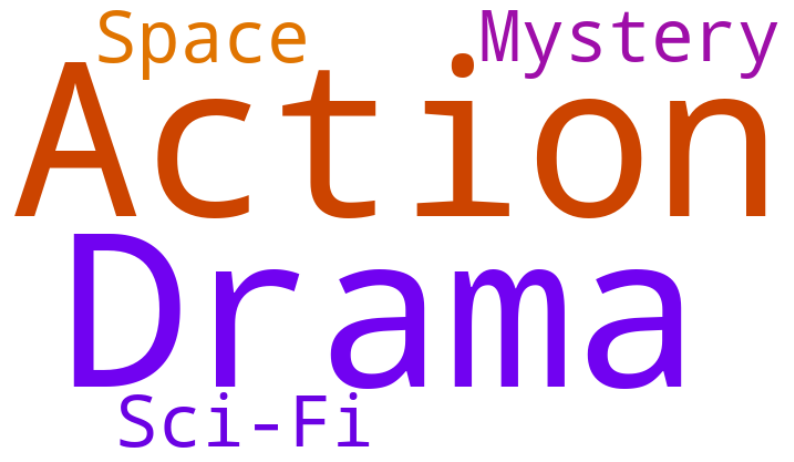

['Action', ' Drama', ' Mystery', ' Sci-Fi', ' Space']

In [79]:
getFavGenre(x,plot=True)

In [80]:
def get_user_preferences(user_id,rating_df,df,plot=False):

    animes_watched_by_user=rating_df[rating_df.user_id==user_id]

    user_rating_percentile=np.percentile(animes_watched_by_user.rating,75) #Storing only top 75% ratings given by the user

    animes_watched_by_user=animes_watched_by_user[animes_watched_by_user.rating >=user_rating_percentile] #Filtering out

    top_animes_user=(
        animes_watched_by_user.sort_values(by="rating",ascending=False).anime_id.values

    )

    anime_df_rows=df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows=anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)
    
    return anime_df_rows

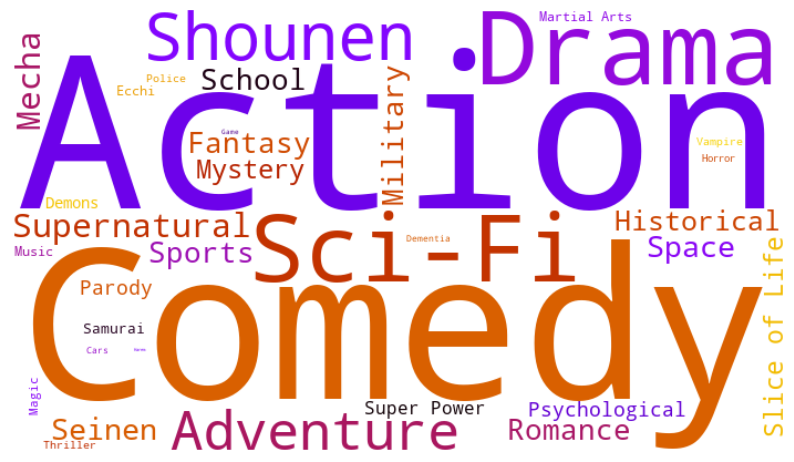

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [81]:
get_user_preferences(11880,rating_df,df,plot=True)

In [95]:
def get_user_recommendation(similar_users,user_pref,df,synopsis_df,rating_df,n=10 ):
    recommended_animes=[]
    anime_list=[]

    for user_id in similar_users.similar_users.values:  #similar_user column return from the function dataframe
        pref_list=get_user_preferences(int(user_id),rating_df,df)

        pref_list=pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)
        
    if anime_list:
            anime_list=pd.DataFrame(anime_list)

            sorted_list=pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n) #getting top n animes from the list

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref=sorted_list[sorted_list.index==anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame=getAnimeFrame(anime_name,df)
                    anime_id=frame.anime_id.values[0]
                    genre=frame.Genres.values[0]
                    synopsis=getSynopsis(int(anime_id),synopsis_df)
                    
                    recommended_animes.append({
                         "n" : n_user_pref,
                         "anime_name" : anime_name,
                         "Genres" : genre,
                         "Synopsis" : synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)



In [96]:
similar_users=find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded) # user id needed to be provided carefully as in data processing user_id with less than 400 no. of aime ratings were removed.

In [97]:
user_pref=get_user_preferences(11880,rating_df,df,plot=False)

In [100]:
get_user_recommendation(similar_users,user_pref,df,synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,10,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."


### HYBRID RECOMMENDOR SYSTEM

In [124]:
def hybrid_recommendation(user_id,user_weight=0.5,content_weight=0.5):
    ### User Recommendation
    similar_users=find_similar_users(int(user_id),user_weights,user2user_encoded,user2user_decoded)
    user_pref=get_user_preferences(user_id,rating_df,df)
    user_recommended_animes=get_user_recommendation(similar_users,user_pref,df,synopsis_df,rating_df)

    user_recommended_anime_list=user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)
    ### Content Recommendation
    content_recommended_animes=[]

    for anime in user_recommended_anime_list:
        similar_animes=find_similar_animes(anime,anime_weights,anime2anime_encoded,anime2anime_decoded,df,synopsis_df) #no. of recommendations

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No Similar anime found {anime}")

    combined_scores={}

    for anime in user_recommended_anime_list:
        combined_scores[anime]=combined_scores.get(anime,0) + user_weight
    
    for anime in content_recommended_animes:
        combined_scores[anime]=combined_scores.get(anime,0) + content_weight
    
    sorted_animes=sorted(combined_scores.items(),key=lambda x:x[1],reverse=True)
    return [anime for anime,score in sorted_animes[:10]]

In [125]:
hybrid_recommendation(11880)

['Code Geass:Lelouch of the Rebellion', 'Code Geass:Lelouch of the Rebellion R2', 'Steins;Gate', 'Your Name.', 'Evangelion:2.0 You Can (Not) Advance', 'Clannad ~After Story~:Another World, Kyou Chapter', 'Your Lie in April', 'Clannad:Another World, Tomoyo Chapter', 'Toradora!', 'A Silent Voice']


['Angel Beats!',
 'Code Geass:Lelouch of the Rebellion R2',
 'Death Note',
 'Attack on Titan',
 'One Punch Man',
 'Code Geass:Lelouch of the Rebellion',
 'Your Name.',
 'Fullmetal Alchemist:Brotherhood',
 'Fate/Zero Season 2',
 'No Game, No Life']

In [ ]:
find_similar_users(11880)